## Enviroment Setup

In [1]:
!pip install alibi-detect

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import shutil
from collections import Counter
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D,\
    Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
from alibi_detect.od import OutlierAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We start by importing the necessary libraries, classes and functions. After that, we create a function that loads all the images from a given path, and converts them to a numpy array. We use that function to create the train and test sets for our model.

In [3]:
def img_to_np(path, resize = True):  
    img_array = []
    fpaths = glob.glob(path, recursive=True)
    for fname in fpaths:
        img = Image.open(fname).convert("RGB")
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    return images

In [4]:
#path_train = "D:\\img\\capsule\\train\\**\*.*"
path_train = "/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/train/**/*.*"

#path_test = "D:\\img\\capsule\\test\\**\*.*"
path_test = "/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/test/**/*.*"

train = img_to_np(path_train)
test = img_to_np(path_test)
train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

Do a check if the train and test sets are populated.

In [5]:
print(train.shape)
print(test.shape)

(219, 64, 64, 3)
(132, 64, 64, 3)


We define the encoder and decoder part of the convolutional autoencoder, by using the TensorFlow/Keras API . We then instantiate the OutlierAE detector class, which takes the encoder and decoder layers as input, and train the model on the appropriate set. 

We also need to define a threshold value, above which the element is flagged as an outlier. We calculate the threshold with the infer_threshold function, which takes the percentage of inlier values as a parameter. This is convenient, but not always possible to do in real-world conditions. 

After that, we detect the outliers of the test set, by using the predict function, which returns a dictionary with predictions for each element. The instance_score key contains the instance level score, and the element is flagged as an outlier in case it is above the threshold. Furthermore, the feature_score key contains the scores of each individual pixel of the image.

In [6]:
encoding_dim = 1024
dense_dim = [8, 8, 128]

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

od = OutlierAE( threshold = 0.001,
                encoder_net=encoder_net,
                decoder_net=decoder_net)

adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train, epochs=100, verbose=True,
       optimizer = adam)

od.infer_threshold(test, threshold_perc=95)

preds = od.predict(test, outlier_type='instance',
            return_instance_score=True,
            return_feature_score=True)

4/4 [=] - 9s 2s/step - loss: 4.8435e-04


In [12]:
outpath= "/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/img/"
for i, fpath in enumerate(glob.glob(path_test)):
  print(fpath)
  if(preds['data']['is_outlier'][i] == 1):
    source = fpath
    shutil.copy(source, outpath)
        
filenames = [os.path.basename(x) for x in glob.glob(path_test, recursive=True)]

dict1 = {'Filename': filenames,
     'instance_score': preds['data']['instance_score'],
     'is_outlier': preds['data']['is_outlier']}
     
df = pd.DataFrame(dict1)
df_outliers = df[df['is_outlier'] == 1]

print(df_outliers)

/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/test/scratch/020.png
/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/test/scratch/019.png
/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/test/scratch/022.png
/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/test/scratch/021.png
/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/test/scratch/003.png
/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/test/scratch/010.png
/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/test/scratch/016.png
/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/test/scratch/009.png
/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/test/scratch/006.png
/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/test/scratch/002.png
/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/test/scratch/014.png
/content/drive/My Drive/Colab Notebooks/IPRAD/MVTec/capsule/test/scratch/018.png
/content/drive/My Drive/Cola

First, we copy all the images flagged as outliers to the img folder. Then, we create a pandas dataframe with the file names of all the images, as well as the predictions of the detector. We create a second dataframe including only the outliers, and print it. The model is fairly accurate, as it detected all the outlier images, and only flagged a few correct images as outliers (false positives).

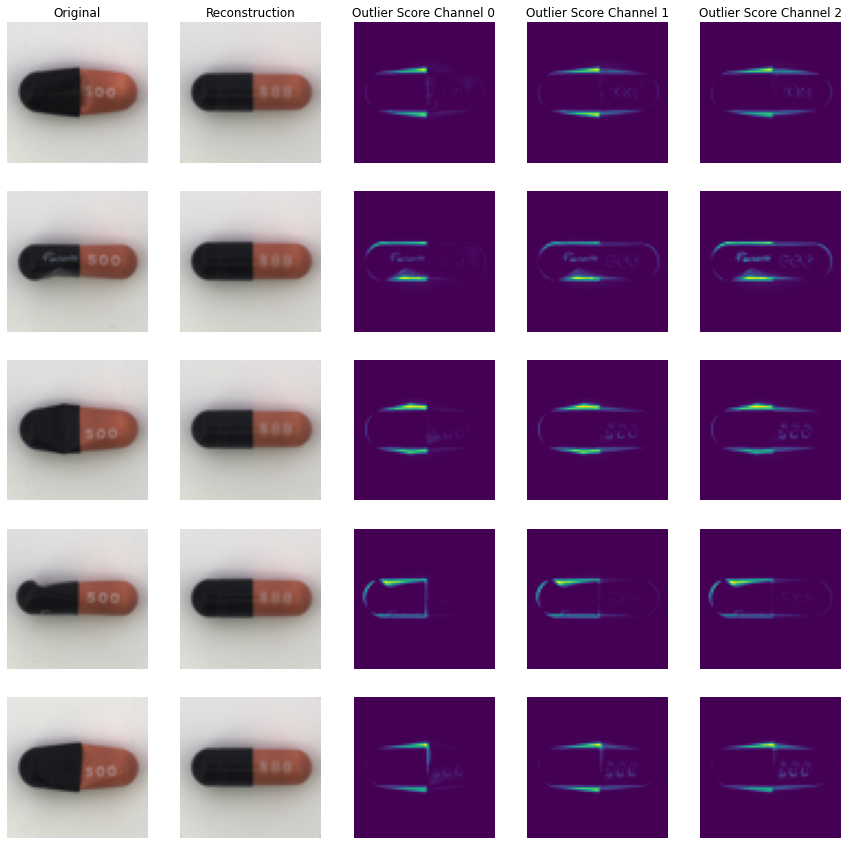

In [13]:
recon = od.ae(test).numpy()

plot_feature_outlier_image(preds, test, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=True,
                           figsize=(15,15))

Finally, we use the plot_feature_outlier_image function to plot the score for each pixel of the outlier elements. This helps us understand better how the outlier detector works. The first column of the graph contains the first five images that have been flagged as outliers. Next we can see each image, as it was reconstructed by the outlier detector. Evidently, the model can only output the image of a normal capsule, and fails to reconstruct the various deformations. The next 3 columns are the visualizations of the feature score for each channel of the image, and can help us locate the problematic areas.